# **MultiVariate Time Series (Laptop Manufacturer)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from pmdarima import auto_arima
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error


pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.style.use('bmh')

In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum() / input_data.isnull().count() * 100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

## **Download Datasets Needed**

In [3]:
to_download_stocks = {
    "Apple": "AAPL",
    "Dell": "DELL",
    "HP": "HPQ",
    "Lenovo": "LNVGY", 
    "Asus": "2357.TW",
    "Microsoft": "MSFT",
    "Google": "GOOG",
    "Acer": "2353.TW"
}
weekly_data = []


for tds in to_download_stocks.items():
    wd = {}
    dataset_dl = yf.download(tds[1], start="2018-01-01", end="2024-01-01")
    dataset_dl.to_csv(f"data/{tds[0]}.csv")

    wd[tds[0]] = dataset_dl.resample('W').last()
    wd[tds[0]]['Name'] = tds[0]

    weekly_data.append(wd[tds[0]])


weekly_df = pd.concat(weekly_data, axis=0)
weekly_df.head(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open  High   Low  Close  Adj Close       Volume   Name
Date                                                              
2018-01-07 43.36 43.84 43.26  43.75      41.17  94640000.00  Apple
2018-01-14 44.04 44.34 43.91  44.27      41.66 101672400.00  Apple
2018-01-21 44.65 44.90 44.35  44.62      41.98 129700400.00  Apple
2018-01-28 43.00 43.00 42.51  42.88      40.35 156572000.00  Apple
2018-02-04 41.50 41.70 40.03  40.12      37.76 346375200.00  Apple
2018-02-11 39.27 39.47 37.56  39.10      36.95 282690400.00  Apple
2018-02-18 43.09 43.71 42.94  43.11      40.73 160704400.00  Apple
2018-02-25 43.42 43.91 43.38  43.88      41.45 135249600.00  Apple
2018-03-04 43.20 44.08 43.11  44.05      41.62 153816000.00  Apple
2018-03-11 44.49 45.00 44.35  44.99      42.51 128740800.00  Apple

## **Re arrange the dataset and apply pivot**

In [43]:
total_weekly_close_df = weekly_df.pivot(columns="Name", values="Adj Close")
total_weekly_close_df = total_weekly_close_df.asfreq('W-SUN')
total_weekly_close_df = total_weekly_close_df.ffill()
total_weekly_close_df.head(10)

Name        Acer  Apple   Asus  Dell  Google    HP  Lenovo  Microsoft
Date                                                                 
2018-01-14 17.56  41.66 163.86 22.72   55.98 18.53    8.52      83.02
2018-01-21 19.79  41.98 172.80 23.18   56.74 19.16    8.54      83.39
2018-01-28 18.65  40.35 173.10 21.67   58.65 19.33    8.72      87.15
2018-02-04 17.60  37.76 174.03 18.57   55.46 18.17    8.02      85.04
2018-02-11 16.65  36.95 167.25 17.63   51.76 16.25    7.43      81.70
2018-02-18 16.28  40.73 166.33 18.28   54.61 17.30    7.42      85.64
2018-02-25 16.75  41.45 169.10 18.80   56.20 17.89    7.52      87.56
2018-03-04 16.79  41.62 167.25 19.30   53.81 19.05    7.60      86.62
2018-03-11 17.63  42.51 166.02 20.56   57.86 19.92    7.67      89.87
2018-03-18 18.07  42.05 170.02 20.42   56.65 19.11    7.71      88.06

In [5]:
missing_data(total_weekly_close_df)

Total  Percent    Types
Name                              
Acer           0     0.00  float64
Apple          0     0.00  float64
Asus           0     0.00  float64
Dell           0     0.00  float64
Google         0     0.00  float64
HP             0     0.00  float64
Lenovo         0     0.00  float64
Microsoft      0     0.00  float64

## **Chart Plot Weekly Series**

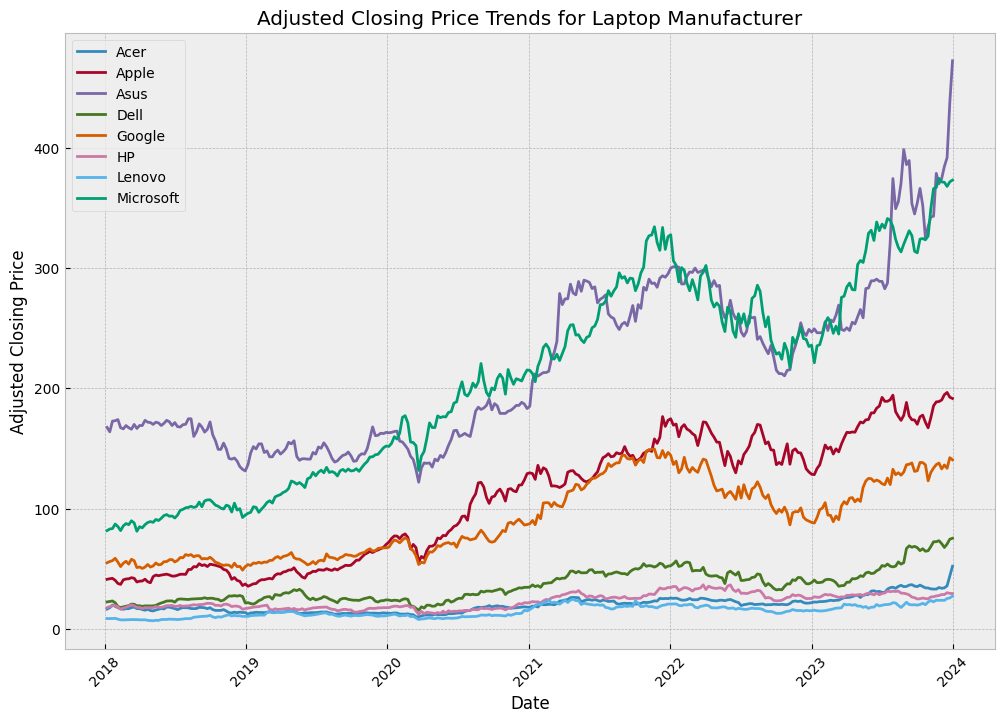

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))

for ticker in total_weekly_close_df.columns:
    ax.plot(total_weekly_close_df.index, total_weekly_close_df[ticker], label=ticker)

ax.set_title('Adjusted Closing Price Trends for Laptop Manufacturer')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Closing Price')
ax.legend()

plt.xticks(rotation=45)
plt.show()

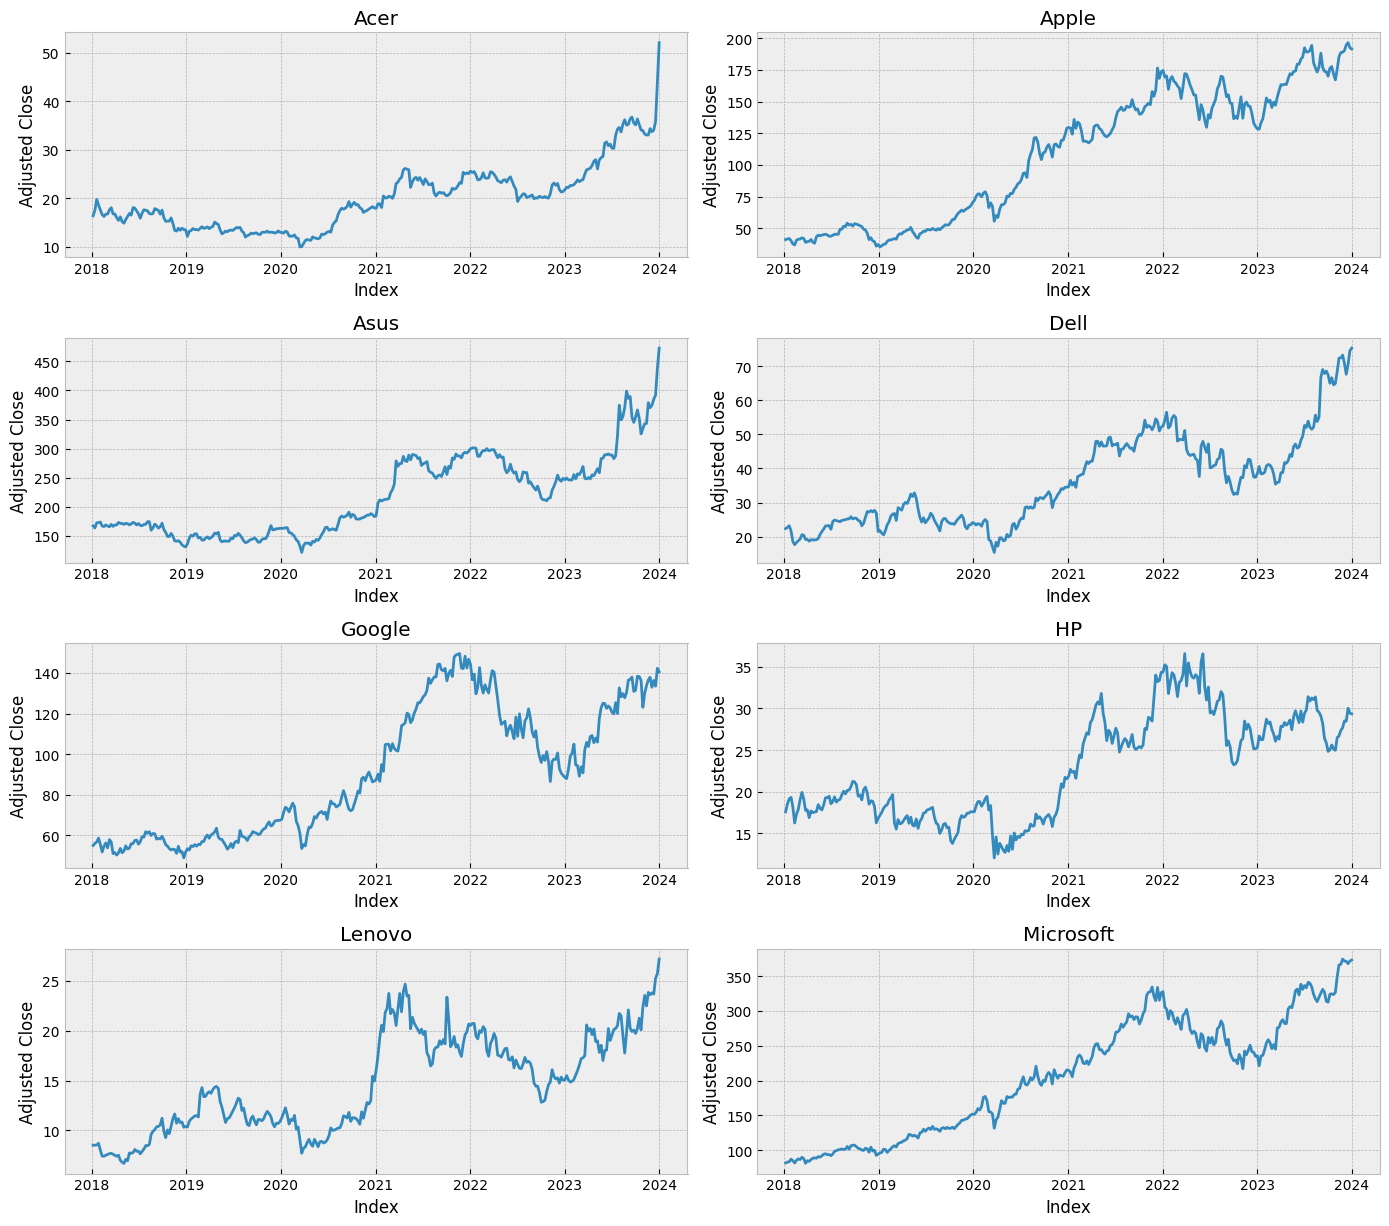

In [7]:
cols = 2
rows = (len(total_weekly_close_df.columns) + cols + 1) // cols

fig, axes = plt.subplots(rows,cols, figsize=(14,3 * rows))
axes = axes.flatten()

for i, col in enumerate(total_weekly_close_df.columns):
    axes[i].plot(total_weekly_close_df[col])
    axes[i].set_title(col)
    axes[i].set_xlabel("Index")
    axes[i].set_ylabel("Adjusted Close")

for j in range(len(total_weekly_close_df.columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


## **Decomposition**

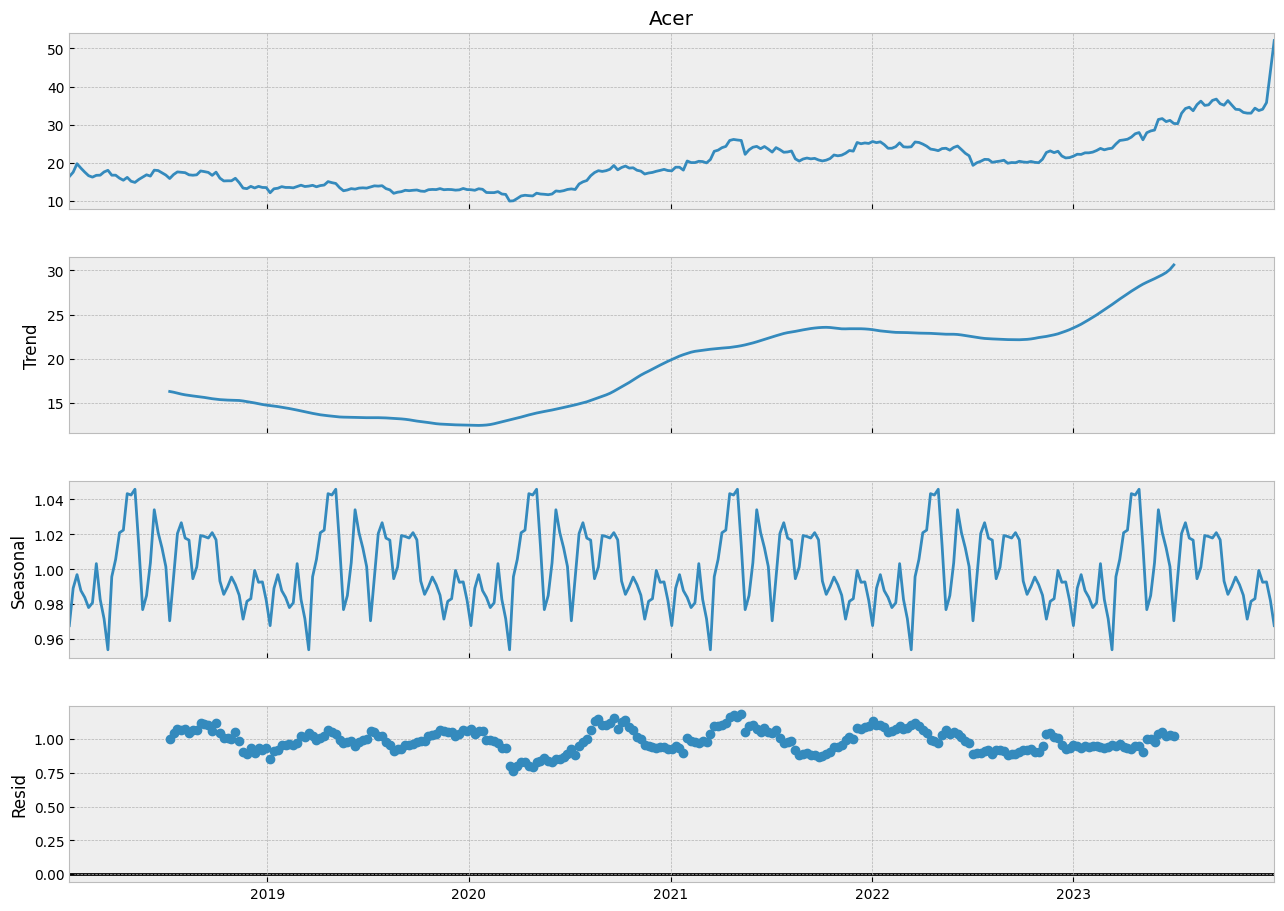

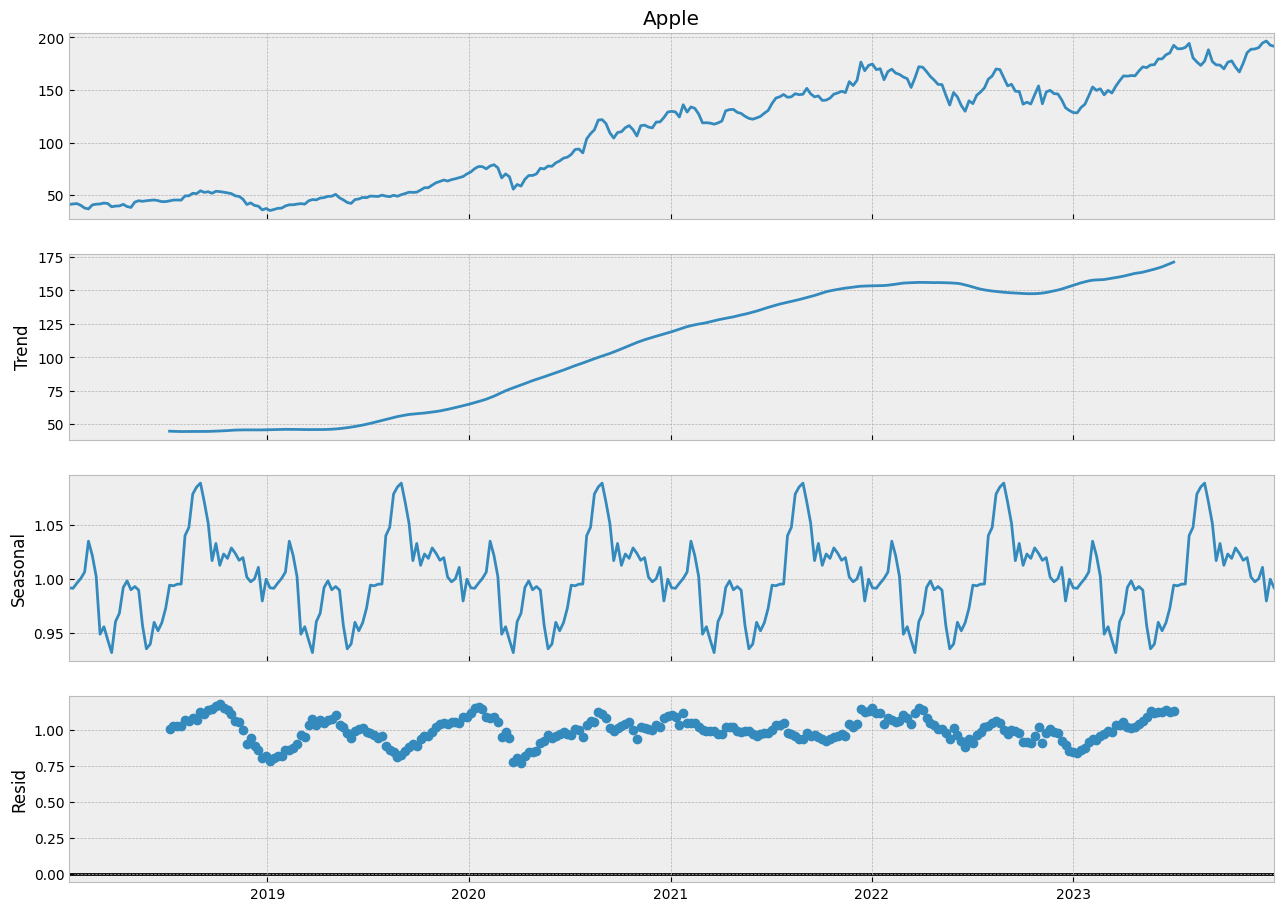

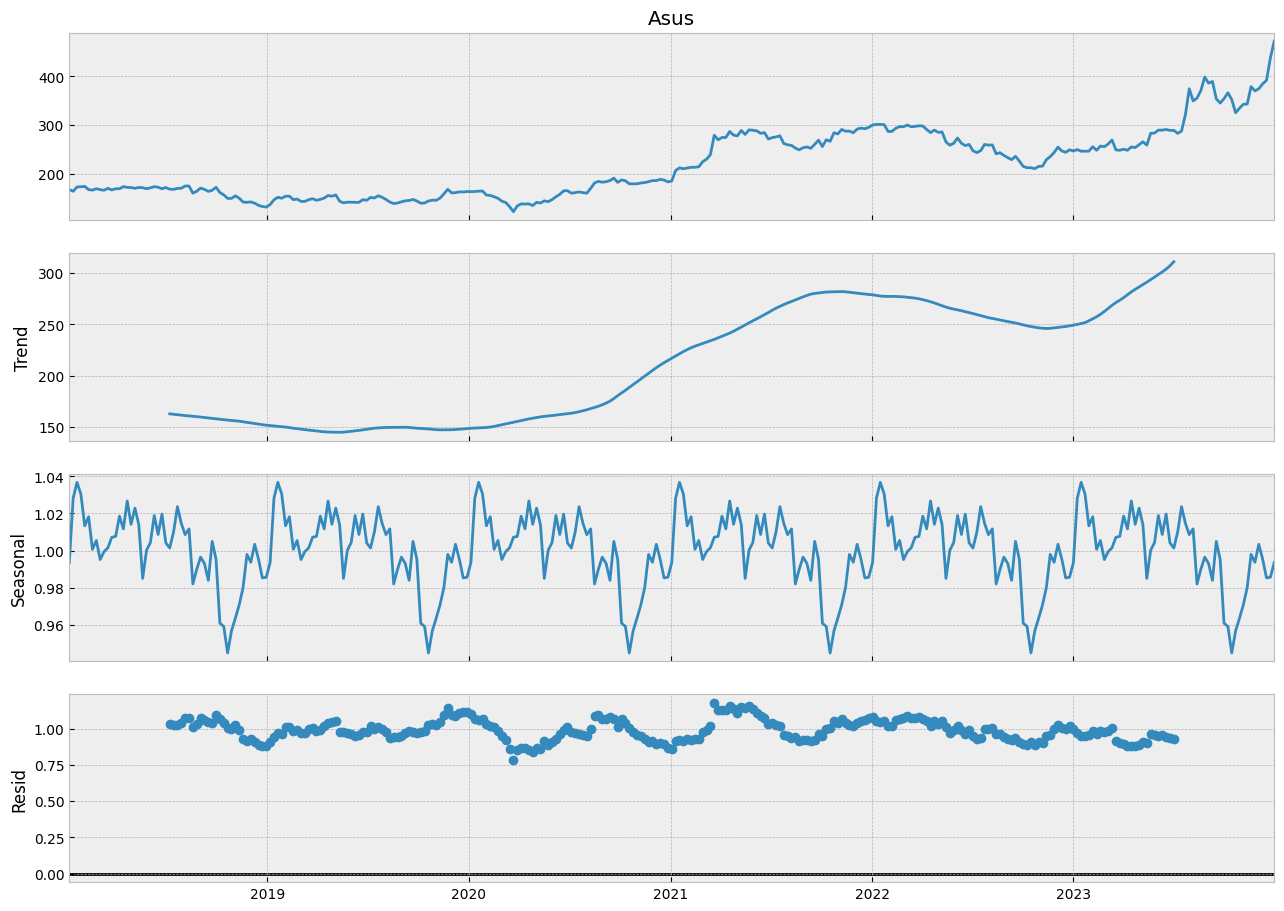

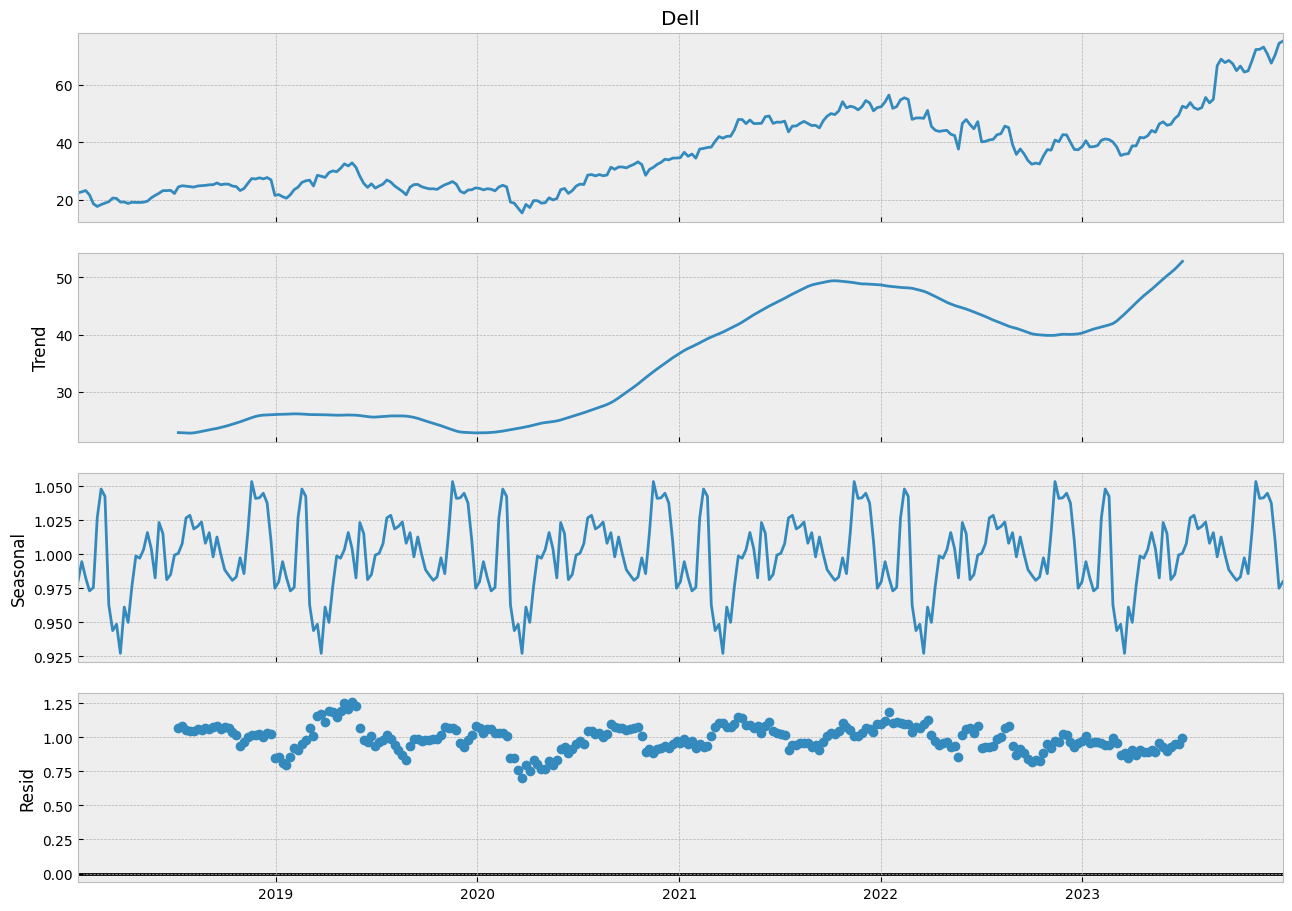

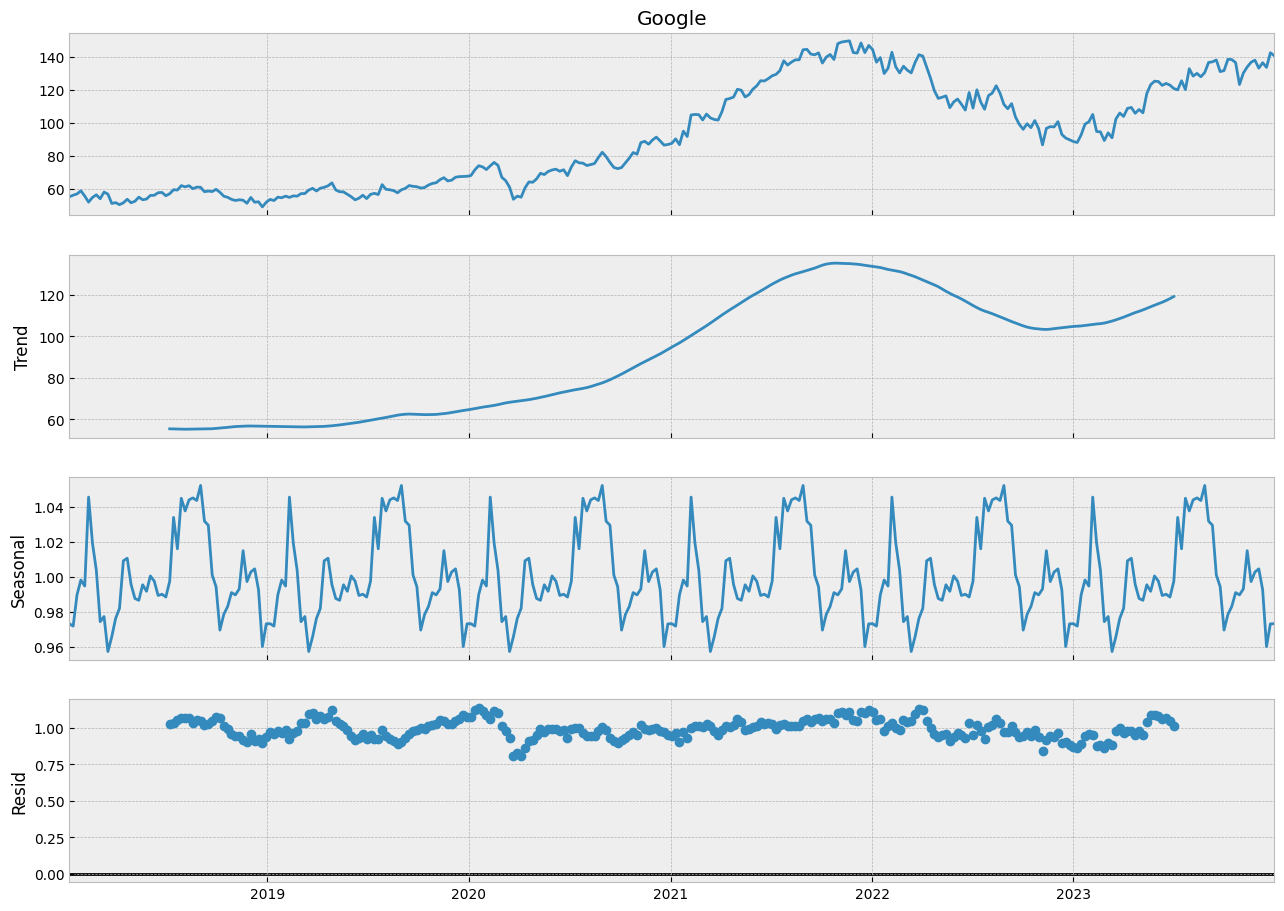

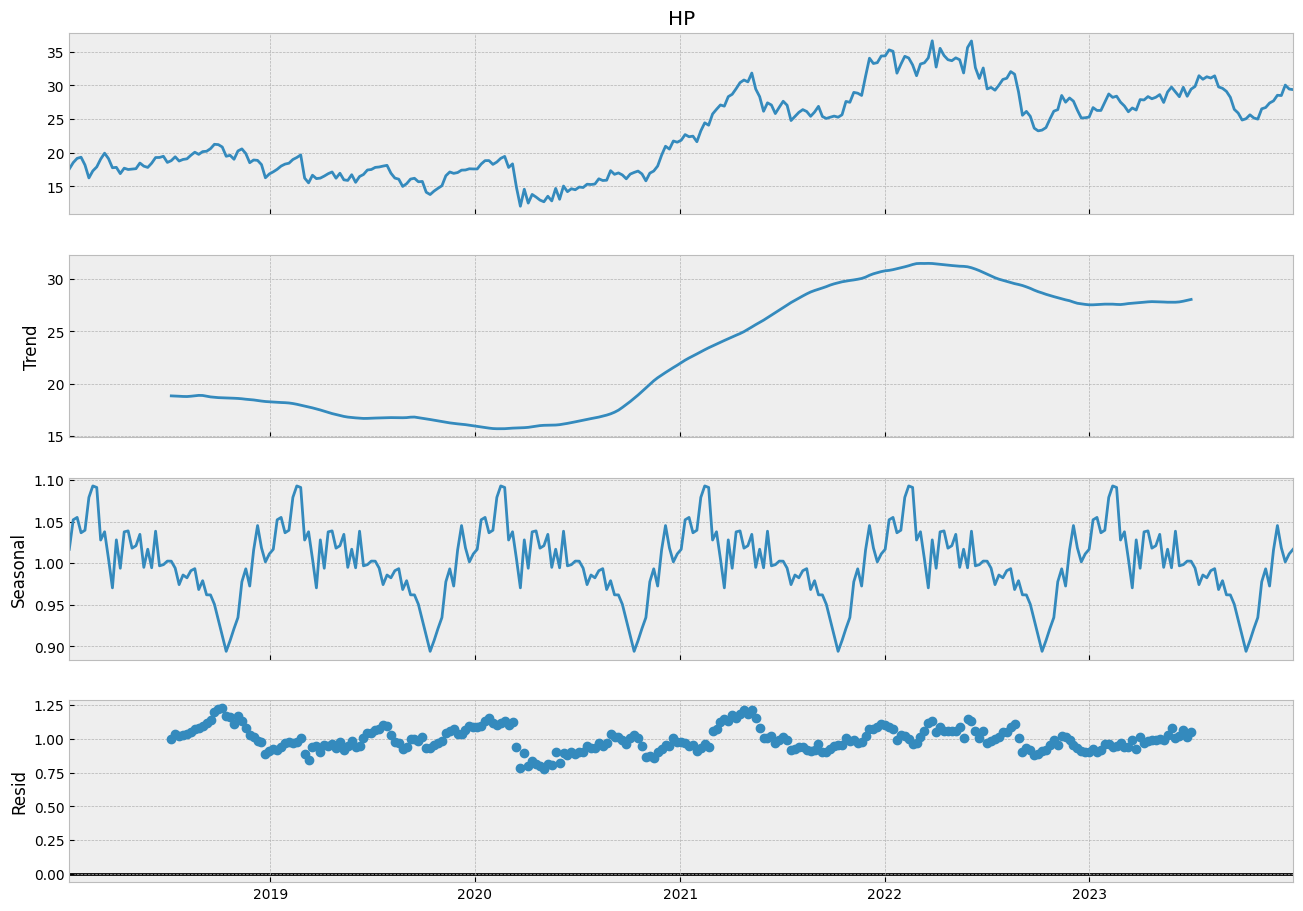

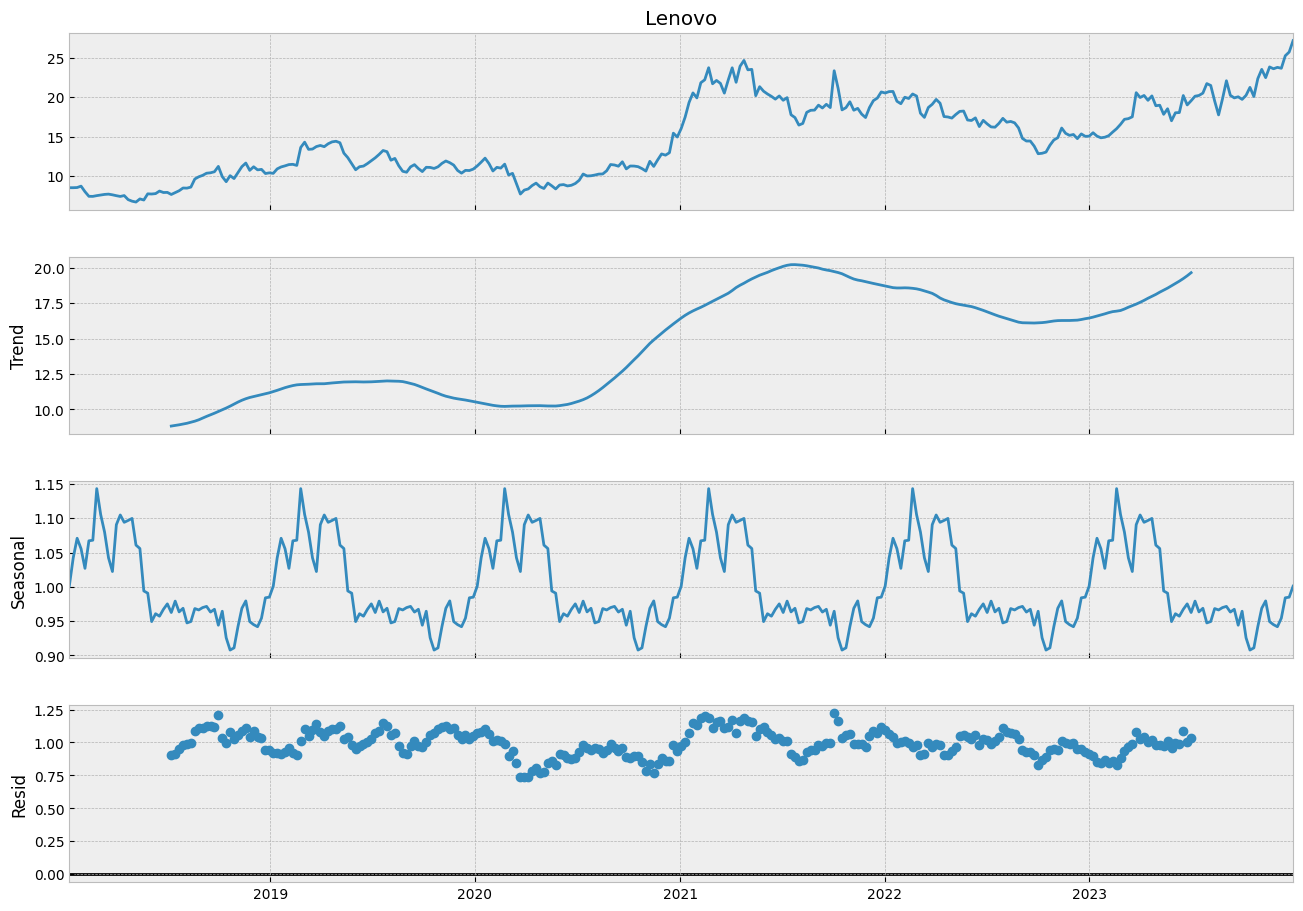

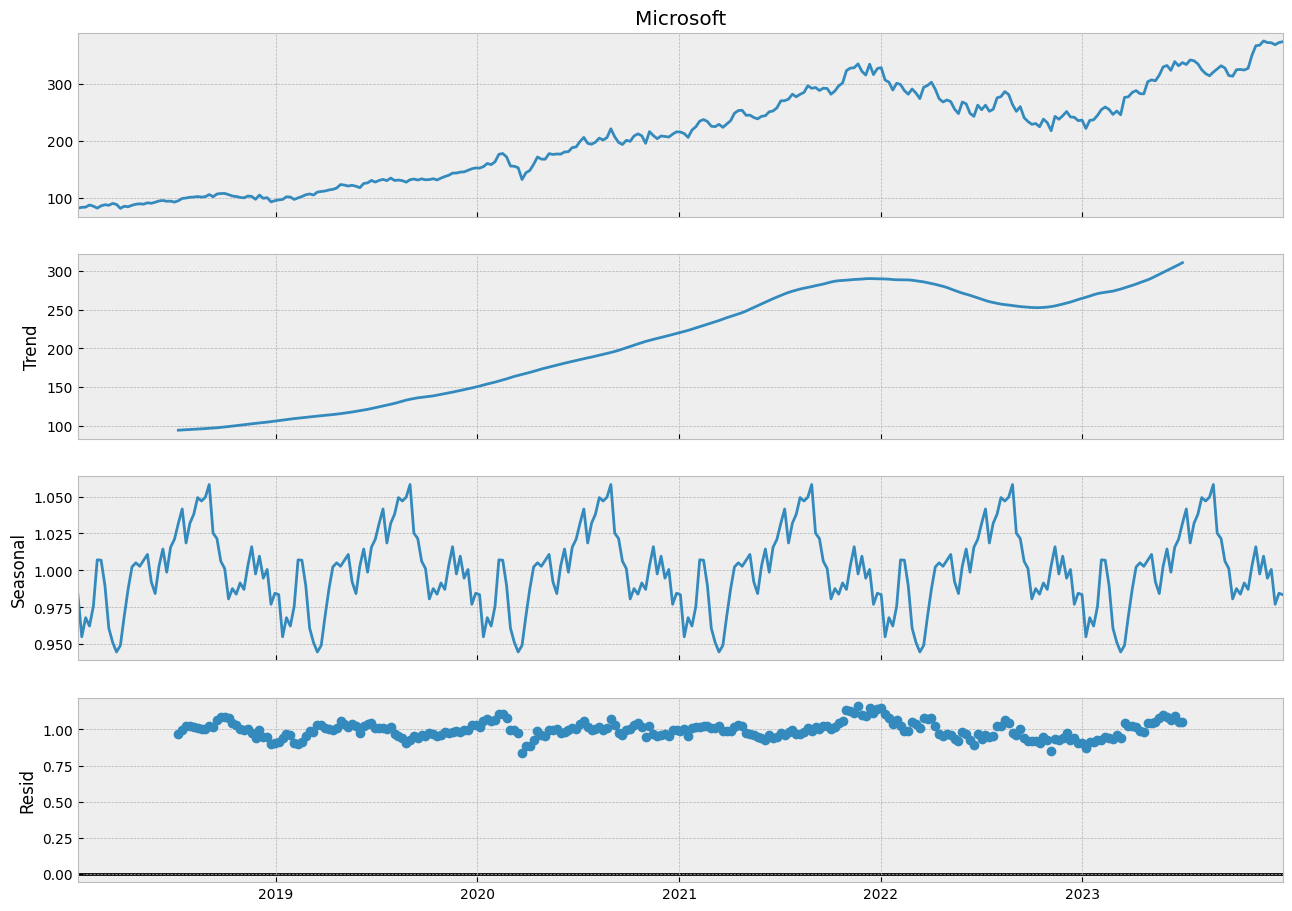

In [8]:
for ticker in total_weekly_close_df.columns:
    decomposition = seasonal_decompose(total_weekly_close_df[ticker], period=52, model='multiplicative')
    fig = decomposition.plot()
    fig.set_size_inches(14,10)
    plt.show()

## **Stationary Validation**

In [9]:
def check_stationary(timeseries):
    result = adfuller(timeseries)
    print('Augmented Dickey-Fuller Test Results: ')
    print('ADF Statistic', result[0])
    print('p-value', result[1])
    print('Critical Values: ')

    for key, value in result[4].items():
        print(f'\t{key}: {value}')

    return result[1] < 0.05


for ticker in total_weekly_close_df.columns:
    is_stationary = check_stationary(total_weekly_close_df[ticker])
    print(f"\nTimes series is {'stationary' if is_stationary else 'non-stationary'}\n")

Augmented Dickey-Fuller Test Results: 
ADF Statistic 2.108909639793267
p-value 0.9987987831881397
Critical Values: 
	1%: -3.451552879535732
	5%: -2.8708786756338407
	10%: -2.571745666091128

Times series is non-stationary

Augmented Dickey-Fuller Test Results: 
ADF Statistic -0.4706092969186729
p-value 0.8976254141059521
Critical Values: 
	1%: -3.4514843502727306
	5%: -2.8708485956333556
	10%: -2.571729625657462

Times series is non-stationary

Augmented Dickey-Fuller Test Results: 
ADF Statistic 1.7156894941173446
p-value 0.998166284598517
Critical Values: 
	1%: -3.4514843502727306
	5%: -2.8708485956333556
	10%: -2.571729625657462

Times series is non-stationary

Augmented Dickey-Fuller Test Results: 
ADF Statistic -0.026114844957518292
p-value 0.9563183810594478
Critical Values: 
	1%: -3.4525611751768914
	5%: -2.87132117782556
	10%: -2.5719816428028888

Times series is non-stationary

Augmented Dickey-Fuller Test Results: 
ADF Statistic -0.47949710290263936
p-value 0.8959557811471647

## **NOTE this is not stationary and we gonna do apply that the timeseries make it stationary**

In [10]:
weekly_df['Adj_Close_Diff'] = weekly_df.groupby('Name')['Adj Close'].transform(lambda x: x.diff())
weekly_df = weekly_df.dropna()

weekly_diff_df = weekly_df.pivot(columns='Name', values='Adj_Close_Diff')
weekly_diff_df = weekly_diff_df.asfreq('W-SUN')
weekly_diff_df = weekly_diff_df.ffill()
weekly_diff_df.head(25)

Name        Acer  Apple  Asus  Dell  Google    HP  Lenovo  Microsoft
Date                                                                
2018-01-14  1.15   0.49 -3.70  0.35    1.00  0.95    0.00       1.31
2018-01-21  2.23   0.32  8.93  0.46    0.76  0.63    0.02       0.37
2018-01-28 -1.15  -1.64  0.31 -1.51    1.91  0.17    0.18       3.76
2018-02-04 -1.05  -2.59  0.92 -3.10   -3.19 -1.16   -0.70      -2.11
2018-02-11 -0.95  -0.81 -6.78 -0.94   -3.70 -1.92   -0.59      -3.34
2018-02-18 -0.37   3.78 -0.92  0.65    2.84  1.04   -0.01       3.94
2018-02-25  0.47   0.73  2.77  0.52    1.60  0.59    0.10       1.92
2018-03-04  0.03   0.17 -1.85  0.49   -2.39  1.16    0.08      -0.94
2018-03-11  0.84   0.89 -1.23  1.26    4.05  0.87    0.07       3.25
2018-03-18  0.44  -0.46  4.00 -0.14   -1.21 -0.81    0.04      -1.81
2018-03-25 -1.28  -3.09 -3.39 -1.26   -5.69 -1.35   -0.09      -6.91
2018-04-01  0.00   0.67  2.46  0.02    0.51  0.06   -0.11       3.81
2018-04-08 -0.78   0.14  0.00 -0.50   -1.23 -0.93   -0.10      -0.97
2018-04-15 -0.54   1.50  4.31  0.42    1.11  0.80    0.11       2.65
2018-04-22  0.74  -2.13 -1.54 -0.06    2.18 -0.20   -0.51       1.79
2018-04-29 -1.01  -0.80 -0.31 -0.01   -2.14  0.07   -0.20       0.76
2018-05-06 -0.30   5.08 -1.54  0.09    0.91  0.06   -0.11      -0.61
2018-05-13  0.78   1.30  1.85  0.36    2.50  0.84    0.40       2.36
2018-05-20  0.61  -0.54 -0.62  1.18   -1.59 -0.46   -0.14      -0.86
2018-05-27  0.61   0.54 -2.16  0.84    0.46 -0.19    0.78       1.87
2018-06-03 -0.34   0.39  1.85  0.74    2.19  0.63   -0.02       2.27
2018-06-10  1.55   0.35  2.46  0.91    0.07  0.84    0.05       0.79
2018-06-17 -0.10  -0.68 -1.23  0.02    1.57  0.01    0.32      -1.40
2018-06-24 -0.61  -0.93 -3.08  0.10    0.16  0.17   -0.18       0.26
2018-07-01 -0.57   0.05  2.46 -1.10   -1.99 -0.91    0.01      -1.68

In [11]:
missing_data(weekly_diff_df)

Total  Percent    Types
Name                              
Acer           0     0.00  float64
Apple          0     0.00  float64
Asus           0     0.00  float64
Dell           0     0.00  float64
Google         0     0.00  float64
HP             0     0.00  float64
Lenovo         0     0.00  float64
Microsoft      0     0.00  float64

In [12]:
for ticker in weekly_diff_df.columns:
    is_stationary_diff = check_stationary(weekly_diff_df[ticker])
    print(f"\nTicker Name: {ticker}")
    print(f"Times series is {'stationary' if is_stationary_diff else 'non-stationary'}\n")

Augmented Dickey-Fuller Test Results: 
ADF Statistic -10.793159522910466
p-value 2.107863213422388e-19
Critical Values: 
	1%: -3.451552879535732
	5%: -2.8708786756338407
	10%: -2.571745666091128

Ticker Name: Acer
Times series is stationary

Augmented Dickey-Fuller Test Results: 
ADF Statistic -17.882313622696397
p-value 2.999158786121461e-30
Critical Values: 
	1%: -3.451552879535732
	5%: -2.8708786756338407
	10%: -2.571745666091128

Ticker Name: Apple
Times series is stationary

Augmented Dickey-Fuller Test Results: 
ADF Statistic -15.618767570725938
p-value 1.7425469567232829e-28
Critical Values: 
	1%: -3.451552879535732
	5%: -2.8708786756338407
	10%: -2.571745666091128

Ticker Name: Asus
Times series is stationary

Augmented Dickey-Fuller Test Results: 
ADF Statistic -3.5240525111200376
p-value 0.007390439263922374
Critical Values: 
	1%: -3.4525611751768914
	5%: -2.87132117782556
	10%: -2.5719816428028888

Ticker Name: Dell
Times series is stationary

Augmented Dickey-Fuller Test Re

In [13]:
weekly_diff_df.shape

(312, 8)

In [14]:
total_weekly_close_df.tail(1)

Name        Acer  Apple   Asus  Dell  Google    HP  Lenovo  Microsoft
Date                                                                 
2023-12-31 52.06 191.59 472.52 75.33  140.58 29.35   27.16     373.25

# **Model Training: VAR Model**

In [15]:
var_model = VAR(weekly_diff_df)
var_model_fitted = var_model.fit(ic="aic")

forecast_steps = 25
forecasted_values = var_model_fitted.forecast(weekly_diff_df.values[-var_model_fitted.k_ar:], steps=forecast_steps)

start_forecased_date = pd.to_datetime("2023-12-31")
forecast_index = pd.date_range(start=start_forecased_date, periods=forecast_steps + 1, freq='W-SUN')[1:]

forecast_df = pd.DataFrame(forecasted_values, index=forecast_index, columns=weekly_diff_df.columns)
last_row = total_weekly_close_df.tail(1)
forecast_cumsum = forecast_df.cumsum() + last_row.values

complete_forecast = pd.concat([last_row, forecast_cumsum])

In [16]:
var_model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 22, Nov, 2024
Time:                     22:17:42
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    13.6884
Nobs:                     311.000    HQIC:                   13.1687
Log likelihood:          -5452.24    FPE:                    370558.
AIC:                      12.8226    Det(Omega_mle):         294944.
--------------------------------------------------------------------
Results for equation Acer
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.071059         0.054794            1.297           0.195
L1.Acer              0.309360         0.071028            4.355           0.000
L1.Apple            -0.013383         0.018120           -0.739  

## **Chart Output with Forecast Data**

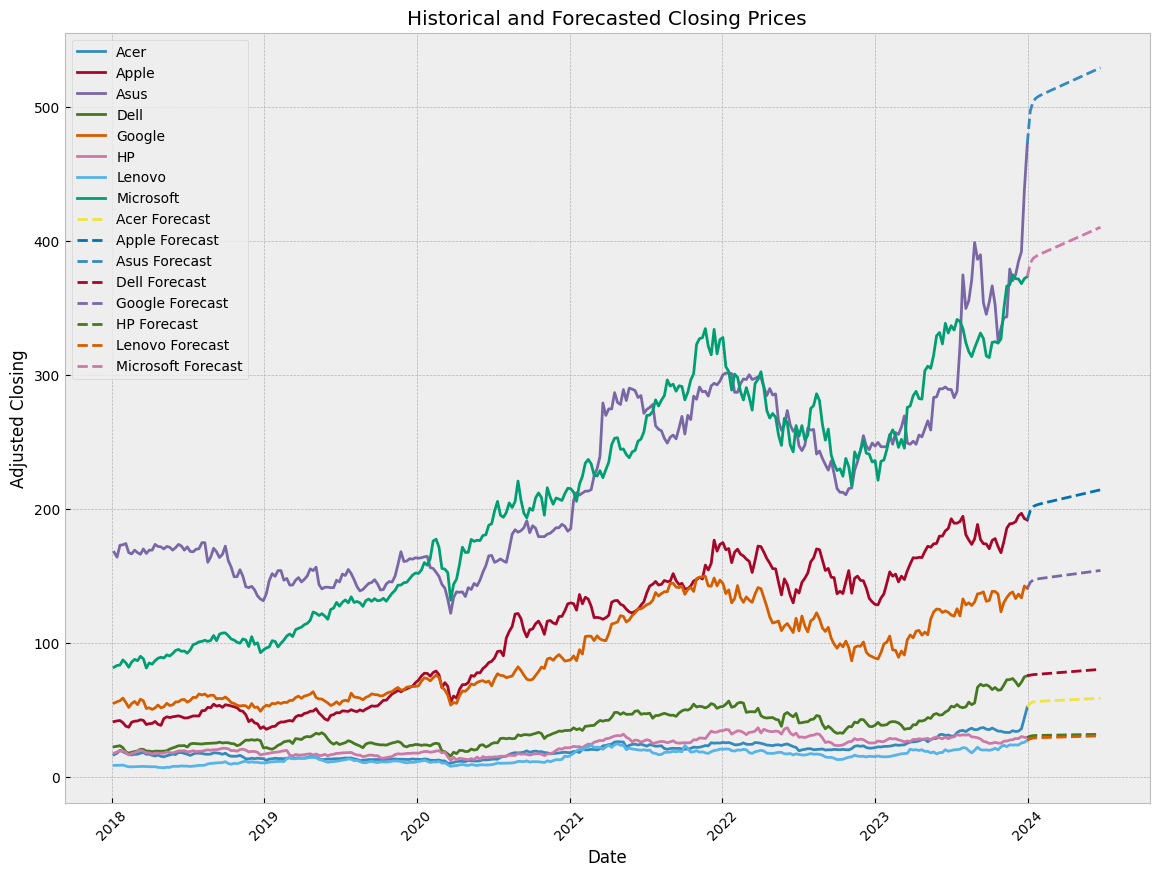

In [17]:
fig, ax = plt.subplots(figsize=(14,10))

for ticker in total_weekly_close_df.columns:
    ax.plot(total_weekly_close_df[ticker], label=ticker)

for col in complete_forecast.columns:
    ax.plot(complete_forecast.index, complete_forecast[col], label=f'{col} Forecast', linestyle='--')


ax.set_title('Historical and Forecasted Closing Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Closing')
ax.legend()

plt.xticks(rotation=45)
plt.show()

## **Auto Regression Integrated Moving Average (ARIMA) Method**

In [18]:
auto_model_stocks = {}

for ticker in weekly_diff_df.columns:
    auto_model_stocks[ticker] = auto_arima(weekly_diff_df[ticker], start_p=0, start_q=0, max_p=5, max_q=5, m=52, seasonal=True, d=None, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.28 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=955.086, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=910.469, Time=0.88 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=875.810, Time=2.37 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=953.215, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=874.900, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=875.982, Time=1.23 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=877.235, Time=3.21 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=861.645, Time=0.13 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=863.523, Time=2.68 sec
 ARIMA(0,1,2)(0,0,1)[52] intercept   : AIC=863.493, Time=2.97 sec
 ARIMA(0,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=6.13 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=862.976, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[52] intercept   : AIC=86

In [19]:
auto_model_stocks

{'Acer': ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 52),
       suppress_warnings=True, with_intercept=False),
 'Apple': ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 52),
       suppress_warnings=True),
 'Asus': ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 52),
       suppress_warnings=True),
 'Dell': ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 52),
       suppress_warnings=True),
 'Google': ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 52),
       suppress_warnings=True),
 'HP': ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 52),
       suppress_warnings=True, with_intercept=False),
 'Lenovo': ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 52),
       suppress_warnings=True, with_intercept=False),
 'Microsoft': ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 52),
       suppress_warnings=True)}

In [ ]:
arima_model = {}
results = {}
forecats_period = 25
forecast = {}
mean_forecast = {}

for ticker in weekly_diff_df.columns.tolist():
    arima_model[ticker] = ARIMA(weekly_diff_df[ticker], order=auto_model_stocks[ticker].order, seasonal_order=auto_model_stocks[ticker].seasonal_order)
    results[ticker] = arima_model[ticker].fit()
    forecast[ticker] = results[ticker].get_forecast(steps=forecats_period)
    mean_forecast[ticker] = forecast[ticker].predicted_mean


In [35]:
mean_forecast_df = {}
forecast_result_df = {}
for ticker in weekly_diff_df.columns.tolist():
    mean_forecast_df[ticker] = mean_forecast[ticker]
    forecast_result_df[ticker] = forecast[ticker]

mean_forecast_df = pd.DataFrame(mean_forecast_df)
mean_forecast_cumsum = mean_forecast_df.cumsum() + total_weekly_close_df.tail(1).values

complete_mean_forecast = pd.concat([total_weekly_close_df.tail(1), mean_forecast_cumsum])
complete_mean_forecast.head(25)

Acer  Apple   Asus  Dell  Google    HP  Lenovo  Microsoft
2023-12-31 52.06 191.59 472.52 75.33  140.58 29.35   27.16     373.25
2024-01-07 55.20 192.07 476.62 75.50  141.20 29.39   27.08     374.18
2024-01-14 56.73 192.56 477.83 75.67  141.42 29.43   27.14     375.12
2024-01-21 57.75 193.04 478.76 75.84  141.70 29.46   27.20     376.05
2024-01-28 58.62 193.52 479.67 76.01  141.97 29.50   27.26     376.99
2024-02-04 59.44 194.00 480.57 76.18  142.25 29.54   27.32     377.92
2024-02-11 60.24 194.48 481.48 76.35  142.52 29.58   27.37     378.86
2024-02-18 61.03 194.97 482.38 76.52  142.80 29.61   27.43     379.79
2024-02-25 61.83 195.45 483.28 76.69  143.07 29.65   27.49     380.72
2024-03-03 62.62 195.93 484.19 76.86  143.35 29.69   27.55     381.66
2024-03-10 63.41 196.41 485.09 77.03  143.62 29.73   27.61     382.59
2024-03-17 64.21 196.89 486.00 77.20  143.90 29.77   27.67     383.53
2024-03-24 65.00 197.38 486.90 77.37  144.17 29.80   27.73     384.46
2024-03-31 65.79 197.86 487.80 77.54  144.45 29.84   27.79     385.40
2024-04-07 66.59 198.34 488.71 77.71  144.72 29.88   27.85     386.33
2024-04-14 67.38 198.82 489.61 77.88  145.00 29.92   27.91     387.27
2024-04-21 68.17 199.31 490.51 78.05  145.27 29.95   27.97     388.20
2024-04-28 68.97 199.79 491.42 78.22  145.55 29.99   28.03     389.13
2024-05-05 69.76 200.27 492.32 78.39  145.82 30.03   28.09     390.07
2024-05-12 70.55 200.75 493.23 78.56  146.10 30.07   28.15     391.00
2024-05-19 71.35 201.23 494.13 78.73  146.37 30.10   28.20     391.94
2024-05-26 72.14 201.72 495.03 78.90  146.65 30.14   28.26     392.87
2024-06-02 72.94 202.20 495.94 79.07  146.92 30.18   28.32     393.81
2024-06-09 73.73 202.68 496.84 79.24  147.20 30.22   28.38     394.74
2024-06-16 74.52 203.16 497.75 79.41  147.47 30.26   28.44     395.67

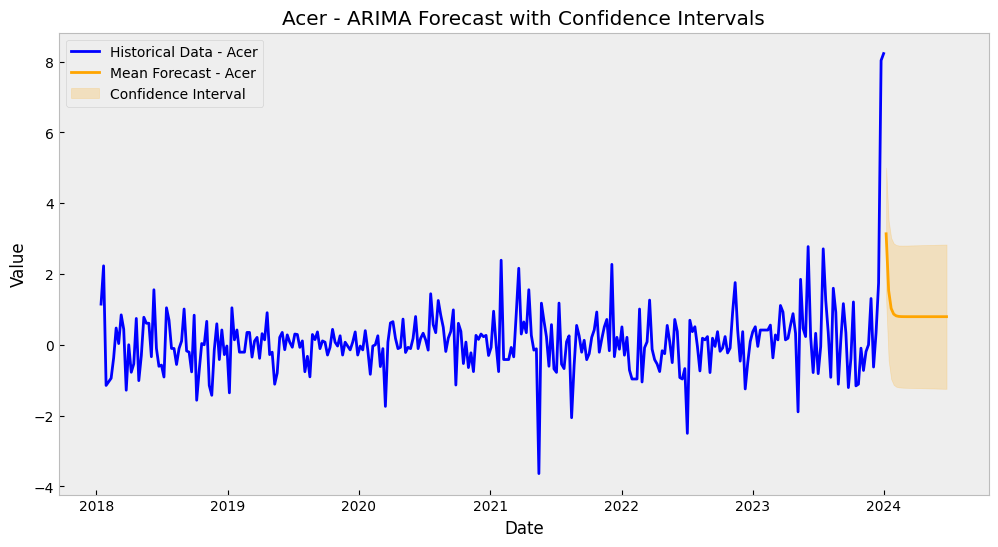

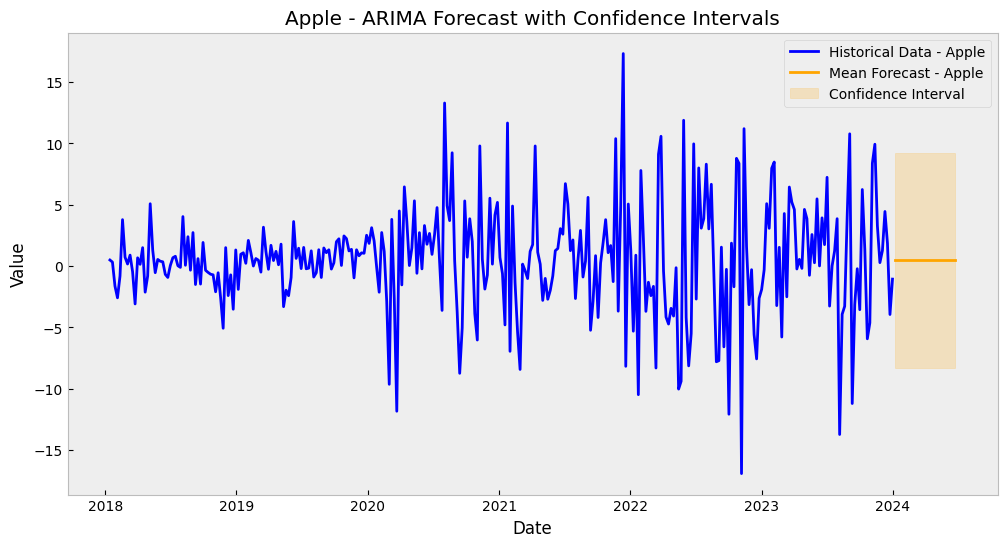

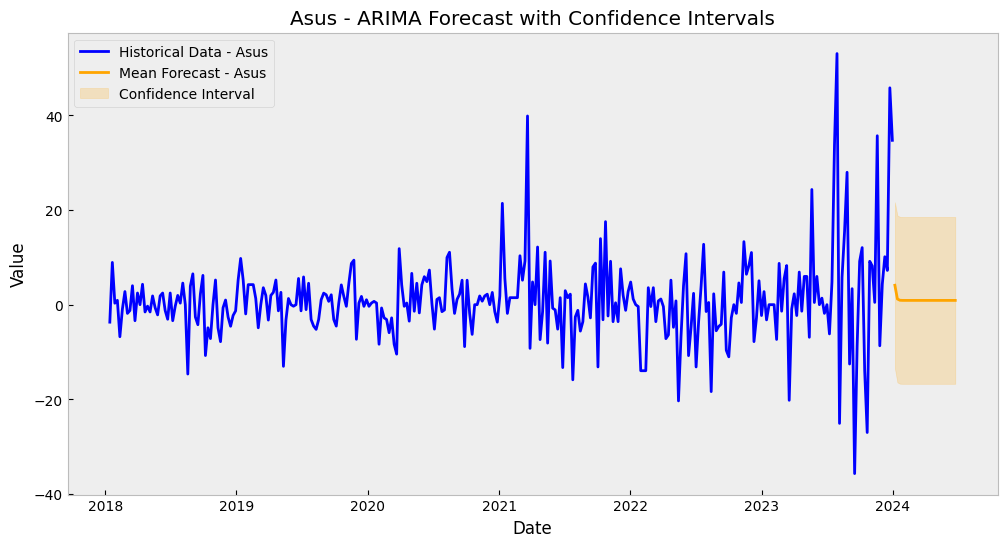

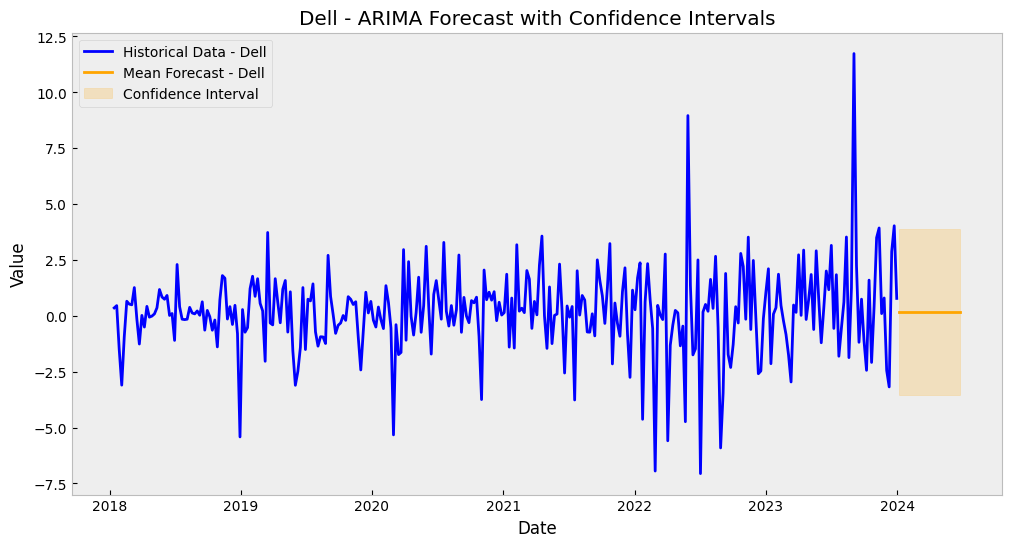

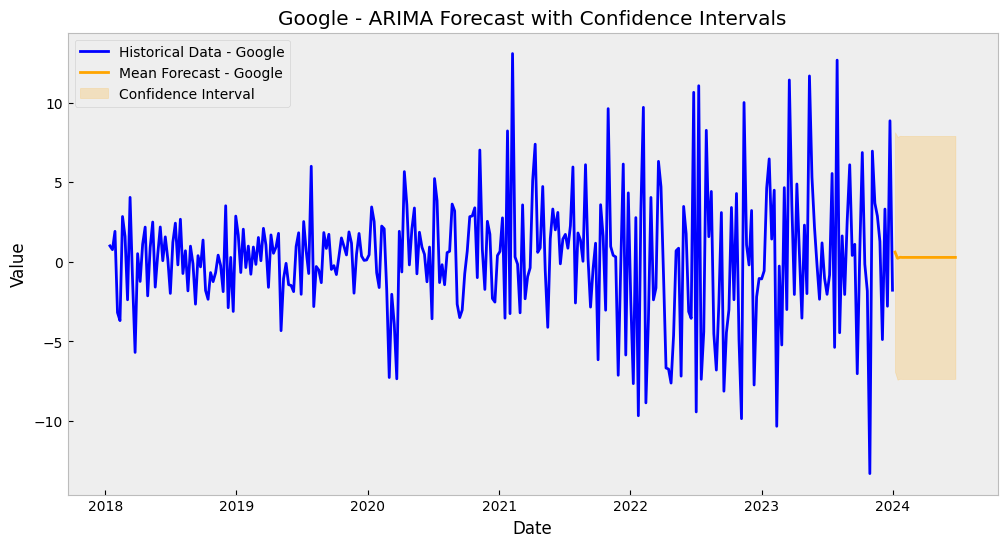

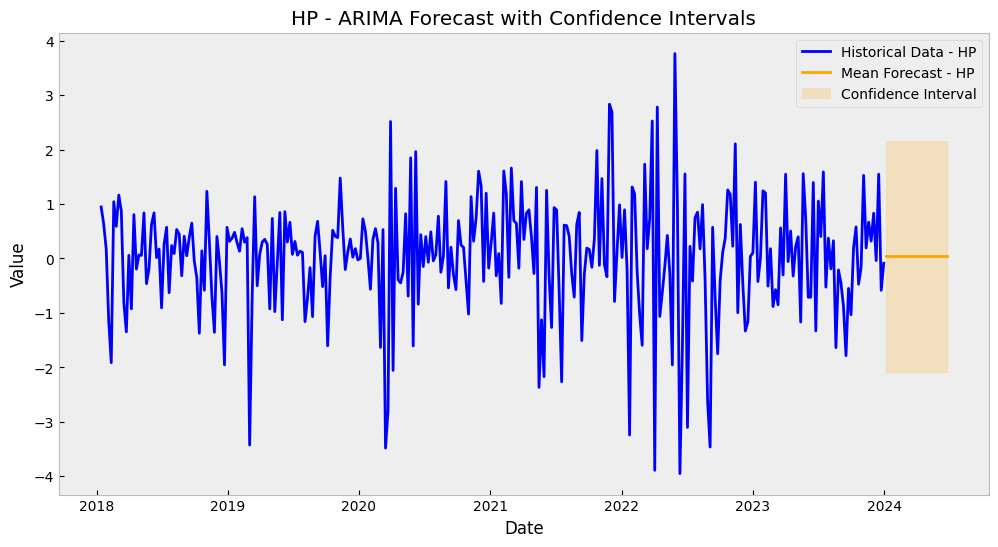

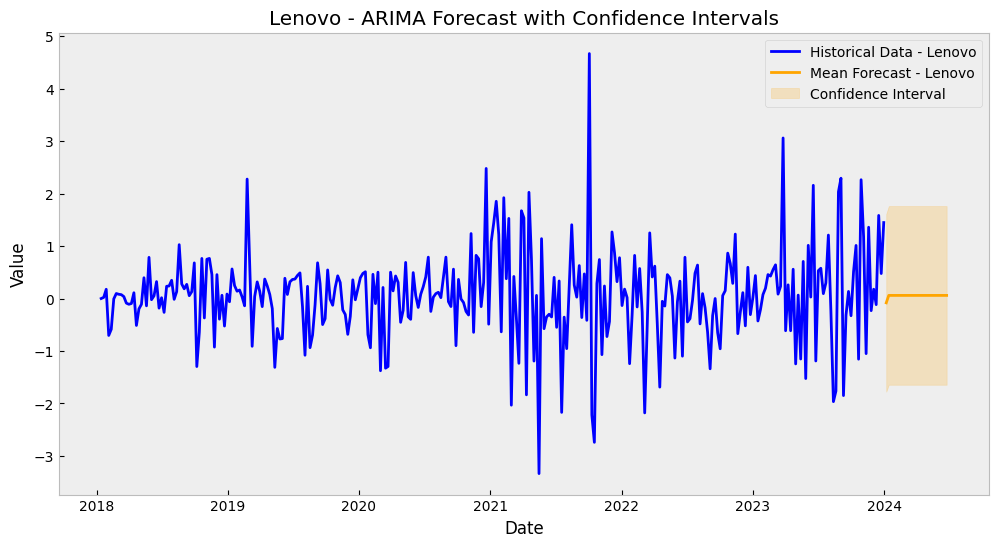

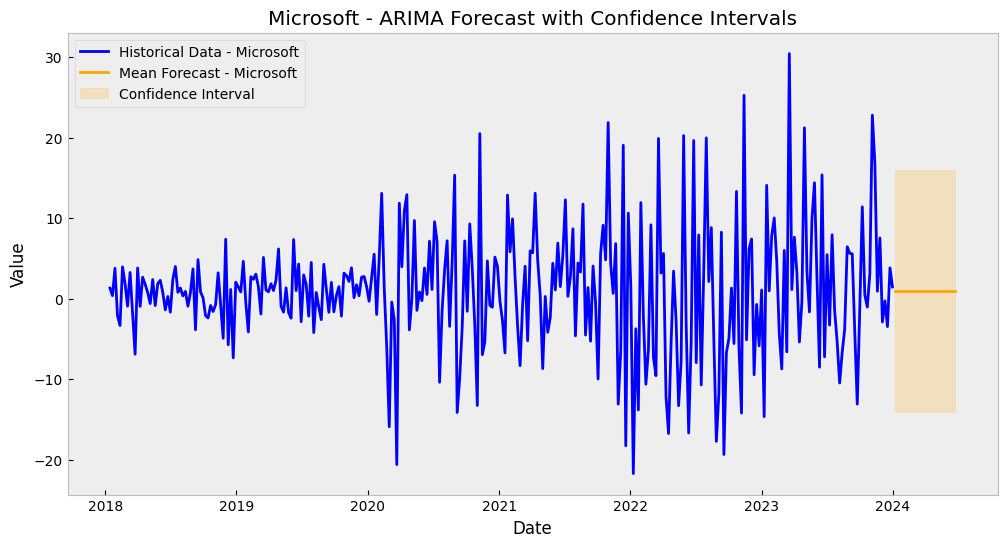

In [ ]:
for ticker in weekly_diff_df.columns.tolist():
    mean_forecast_values = forecast[ticker].predicted_mean
    conf_int = forecast[ticker].conf_int()


    forecast_index = pd.date_range(start=weekly_diff_df.index[-1] + pd.Timedelta(weeks=1), 
                                   periods=forecats_period, freq='W')

    plt.figure(figsize=(12, 6))
    plt.plot(weekly_diff_df.index, weekly_diff_df[ticker], label=f'Historical Data - {ticker}', color='blue')
    plt.plot(forecast_index, mean_forecast_values, label=f'Mean Forecast - {ticker}', color='orange')
    plt.fill_between(forecast_index, 
                     conf_int.iloc[:, 0], 
                     conf_int.iloc[:, 1], 
                     color='orange', alpha=0.2, label='Confidence Interval')

    # Labels and legend
    plt.title(f'{ticker} - ARIMA Forecast with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

    

## **Model Performance Metrics**

In [41]:
ticker_performance_metrics = {}
for ticker in weekly_diff_df.columns.tolist():
    actual_values = total_weekly_close_df[ticker]
    last_observed_value = actual_values.iloc[-1]
    reconstructed_forecast = mean_forecast[ticker].cumsum() + last_observed_value
    actual_forecast_values = total_weekly_close_df[ticker].iloc[-len(reconstructed_forecast):]

    mse = mean_squared_error(actual_forecast_values, reconstructed_forecast)
    rmse = root_mean_squared_error(actual_forecast_values, reconstructed_forecast)
    mae = mean_absolute_error(actual_forecast_values, reconstructed_forecast)

    ticker_performance_metrics[ticker] = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae
    }

    # Print the metrics
    print(f"For stock {ticker}:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}\n")
    


For stock Acer:
Mean Squared Error (MSE): 930.36
Root Mean Squared Error (RMSE): 30.50
Mean Absolute Error (MAE): 29.98

For stock Apple:
Mean Squared Error (MSE): 305.70
Root Mean Squared Error (RMSE): 17.48
Mean Absolute Error (MAE): 15.43

For stock Asus:
Mean Squared Error (MSE): 15830.21
Root Mean Squared Error (RMSE): 125.82
Mean Absolute Error (MAE): 121.34

For stock Dell:
Mean Squared Error (MSE): 205.32
Root Mean Squared Error (RMSE): 14.33
Mean Absolute Error (MAE): 12.72

For stock Google:
Mean Squared Error (MSE): 148.21
Root Mean Squared Error (RMSE): 12.17
Mean Absolute Error (MAE): 11.32

For stock HP:
Mean Squared Error (MSE): 8.04
Root Mean Squared Error (RMSE): 2.84
Mean Absolute Error (MAE): 2.37

For stock Lenovo:
Mean Squared Error (MSE): 39.14
Root Mean Squared Error (RMSE): 6.26
Mean Absolute Error (MAE): 5.96

For stock Microsoft:
Mean Squared Error (MSE): 2329.08
Root Mean Squared Error (RMSE): 48.26
Mean Absolute Error (MAE): 44.85



## **Holt Winters Exponential Smoothing**

In [44]:
models = []
specifications = [
    {
        'name': 'Fixed Parameters',
        'trend': 'add',
        'seasonal': 'add',
        'damped_trend': True
    },
    {
        'name': "Multiplicative Seasonal",
        'trend': 'add',
        'seasonal': 'mul',
        'damped_trend': True
    },
    {
        'name': "Multiplicative Trend",
        'trend': 'mul',
        'seasonal': 'add',
        'damped_trend': True
    }
]
fitted_models = {}


for col in total_weekly_close_df.columns: 
    fitted_models[col] = []  
    for spec in specifications:
        model = ExponentialSmoothing(
            total_weekly_close_df[col],  
            seasonal_periods=52,    
            trend=spec['trend'],
            seasonal=spec['seasonal'],
            damped_trend=spec['damped_trend']
        ).fit(
            smoothing_level=0.2,
            smoothing_trend=0.1,
            smoothing_seasonal=0.1,
            damping_trend=0.98,
            optimized=False
        )
        fitted_models[col].append({
            'name': spec['name'],
            'model': model
        })

In [45]:
evaluation_results = {}

for col in total_weekly_close_df.columns:
    evaluation_results[col] = []
    for spec in fitted_models[col]:
        model = spec['model']
        name = spec['name']
        
        # Calculate metrics: MSE, RMSE, MAE
        mse = mean_squared_error(total_weekly_close_df[col], model.fittedvalues)
        rmse = root_mean_squared_error(total_weekly_close_df[col], model.fittedvalues)
        mae = mean_absolute_error(total_weekly_close_df[col], model.fittedvalues)
        
        # Store results
        evaluation_results[col].append({
            'name': name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'model': model
        })

In [46]:
evaluation_results

{'Acer': [{'name': 'Fixed Parameters',
   'MSE': 2.4800021099978804,
   'RMSE': 1.5748022447272167,
   'MAE': 1.033671753209299,
   'model': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x20bec5643d0>},
  {'name': 'Multiplicative Seasonal',
   'MSE': 2.5098820232243604,
   'RMSE': 1.5842607181977215,
   'MAE': 1.0187362271176459,
   'model': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x20beb6c4150>},
  {'name': 'Multiplicative Trend',
   'MSE': 2.5083307428803514,
   'RMSE': 1.583771051282461,
   'MAE': 1.0458868140054585,
   'model': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x20bec736d10>}],
 'Apple': [{'name': 'Fixed Parameters',
   'MSE': 51.85428504249443,
   'RMSE': 7.200991948509207,
   'MAE': 5.723493961131169,
   'model': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x20bec53e610>},
  {'name': 'Multiplicative Seasonal',
   'MSE': 55.77952172987261,
   'RMSE': 7.4685689211436355,
   'MAE': 

In [47]:
for col, results in evaluation_results.items():
    print(f"\nPerformance for {col}:")
    for res in results:
        print(f"Specification: {res['name']}")
        print(f"MSE: {res['MSE']:.2f}, RMSE: {res['RMSE']:.2f}, MAE: {res['MAE']:.2f}")


Performance for Acer:
Specification: Fixed Parameters
MSE: 2.48, RMSE: 1.57, MAE: 1.03
Specification: Multiplicative Seasonal
MSE: 2.51, RMSE: 1.58, MAE: 1.02
Specification: Multiplicative Trend
MSE: 2.51, RMSE: 1.58, MAE: 1.05

Performance for Apple:
Specification: Fixed Parameters
MSE: 51.85, RMSE: 7.20, MAE: 5.72
Specification: Multiplicative Seasonal
MSE: 55.78, RMSE: 7.47, MAE: 5.65
Specification: Multiplicative Trend
MSE: 52.52, RMSE: 7.25, MAE: 5.75

Performance for Asus:
Specification: Fixed Parameters
MSE: 216.39, RMSE: 14.71, MAE: 10.13
Specification: Multiplicative Seasonal
MSE: 217.15, RMSE: 14.74, MAE: 10.08
Specification: Multiplicative Trend
MSE: 222.96, RMSE: 14.93, MAE: 10.25

Performance for Dell:
Specification: Fixed Parameters
MSE: 7.46, RMSE: 2.73, MAE: 2.06
Specification: Multiplicative Seasonal
MSE: 7.75, RMSE: 2.78, MAE: 2.12
Specification: Multiplicative Trend
MSE: 7.49, RMSE: 2.74, MAE: 2.07

Performance for Google:
Specification: Fixed Parameters
MSE: 24.20,

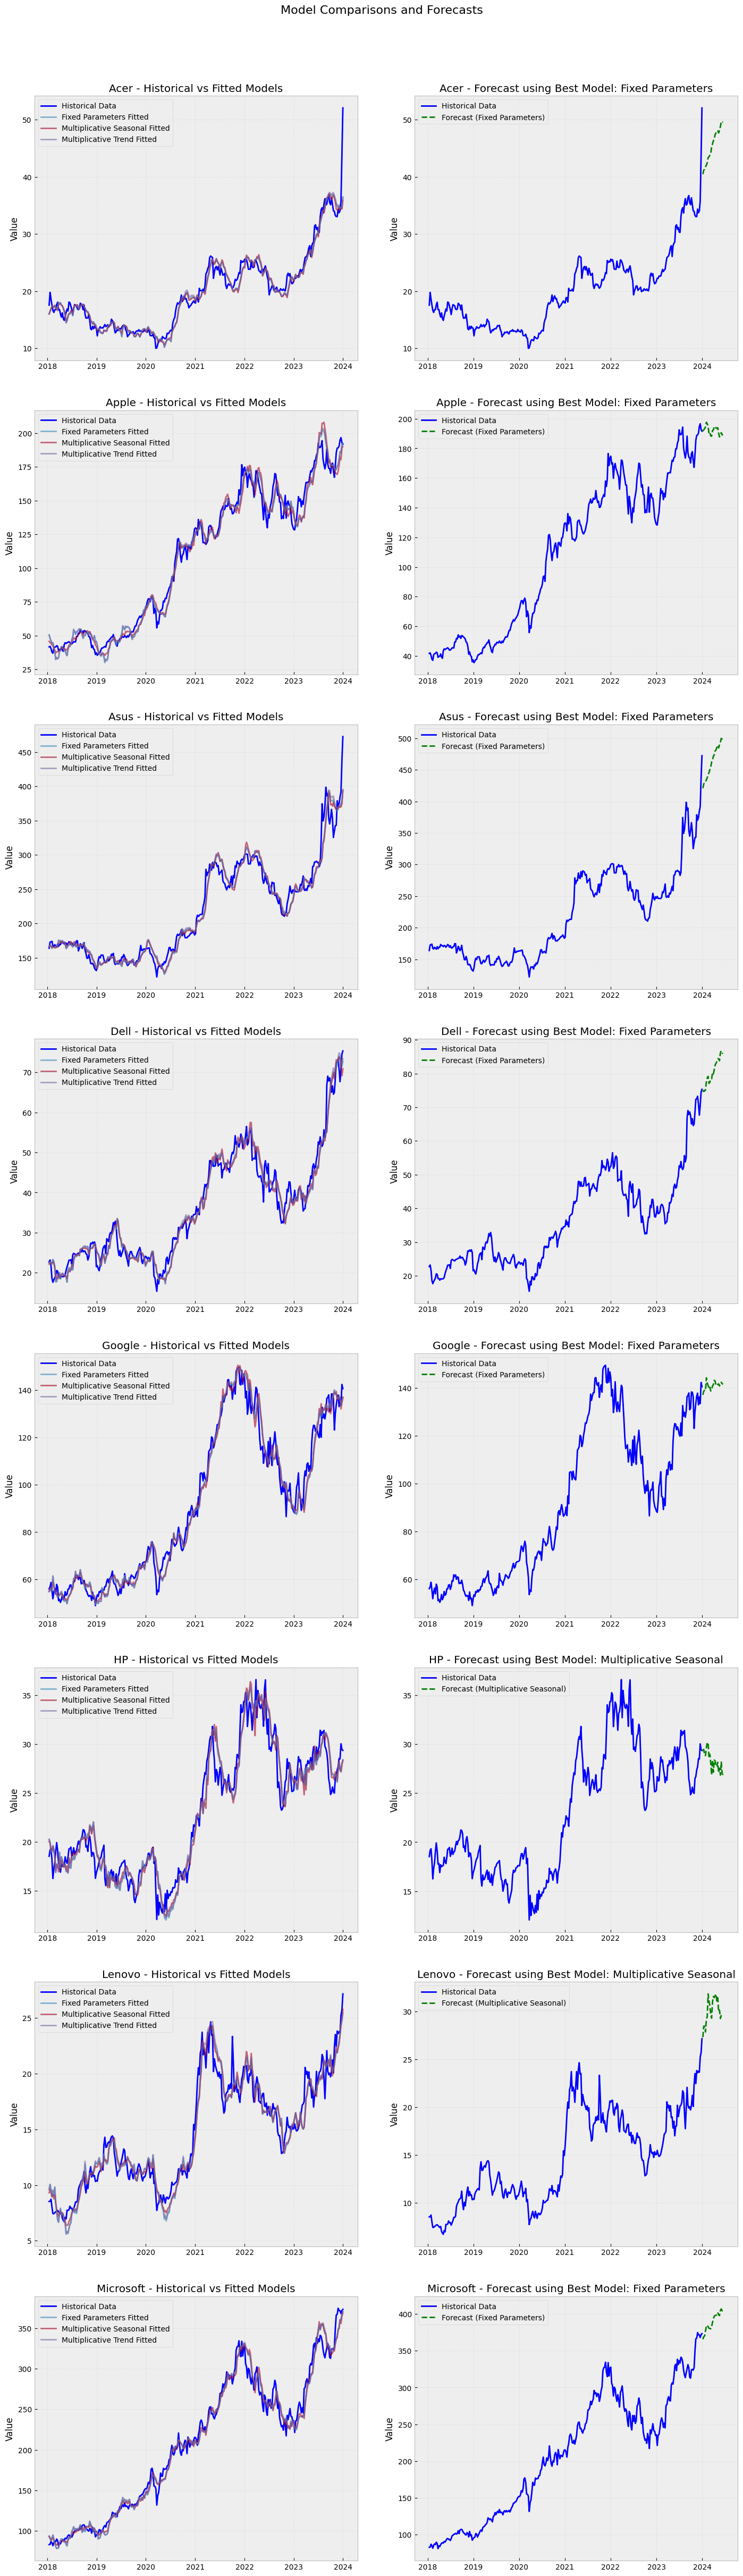

In [48]:
fig, axs = plt.subplots(len(total_weekly_close_df.columns), 2, figsize=(15, 6 * len(total_weekly_close_df.columns)))
fig.tight_layout(pad=5.0)

for idx, col in enumerate(total_weekly_close_df.columns):
    
    ax1 = axs[idx, 0]
    ax1.plot(total_weekly_close_df.index, total_weekly_close_df[col], label="Historical Data", color='blue')
    for result in evaluation_results[col]:
        ax1.plot(result['model'].fittedvalues.index, result['model'].fittedvalues, label=f"{result['name']} Fitted", alpha=0.6)
    ax1.set_title(f"{col} - Historical vs Fitted Models")
    ax1.set_ylabel('Value')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

   
    best_model = min(evaluation_results[col], key=lambda x: x['MSE'])  # Select model with the lowest MSE
    forecast_index = pd.date_range(total_weekly_close_df.index[-1], periods=25, freq='W')
    forecast = best_model['model'].forecast(steps=25)
    forecast_series = pd.Series(forecast, index=forecast_index)

    ax2 = axs[idx, 1]
    ax2.plot(total_weekly_close_df.index, total_weekly_close_df[col], label="Historical Data", color='blue')
    ax2.plot(forecast_series.index, forecast_series, label=f"Forecast ({best_model['name']})", color="green", linestyle="--")
    ax2.set_title(f"{col} - Forecast using Best Model: {best_model['name']}")
    ax2.set_ylabel('Value')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# Adjust layout for better readability
plt.suptitle("Model Comparisons and Forecasts", fontsize=16, y=1.02)
plt.show()